In [1]:
import warnings
import os
from datetime import datetime

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import argparse
import config

parser = argparse.ArgumentParser(description="Trains a CARLA agent")
parser.add_argument("--host", default="localhost", type=str, help="IP of the host server (default: 127.0.0.1)")
parser.add_argument("--port", default=2000, type=int, help="TCP port to listen to (default: 2000)")
parser.add_argument("--total_timesteps", type=int, default=1_000_000, help="Total timestep to train for")
parser.add_argument("--start_carla", action="store_true", help="If True, start a CARLA server")
parser.add_argument("--no_render", action="store_false", help="If True, render the environment")
parser.add_argument("--fps", type=int, default=15, help="FPS to render the environment")
parser.add_argument("--num_checkpoints", type=int, default=100, help="Checkpoint number")
parser.add_argument("--log_dir", type=str, default="tensorboard", help="Directory to save logs")
parser.add_argument("--device", type=str, default="cuda:0", help="cpu, cuda:0, cuda:1, cuda:2")
parser.add_argument("--config", type=str, default="1", help="Config to use (default: vlm_rl)")

args = vars(parser.parse_args(args=[]))
CONFIG = config.set_config(args["config"])
CONFIG.algorithm_params.device = args["device"]

from stable_baselines3 import PPO, DDPG, SAC
from clip.clip_rewarded_sac import CLIPRewardedSAC
from clip.clip_rewarded_ppo import CLIPRewardedPPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.logger import configure
from carla_env.envs.carla_route_env import CarlaRouteEnv
from carla_env.state_commons import create_encode_state_fn
from carla_env.rewards import reward_functions
from utils import HParamCallback, TensorboardCallback, write_json, parse_wrapper_class

os.makedirs(args["log_dir"], exist_ok=True)

algorithm_dict = {"PPO": PPO, "DDPG": DDPG, "SAC": SAC, "CLIP-SAC": CLIPRewardedSAC, "CLIP-PPO": CLIPRewardedPPO}
if CONFIG.algorithm not in algorithm_dict:
    raise ValueError("Invalid algorithm name")

AlgorithmRL = algorithm_dict[CONFIG.algorithm]

observation_space, encode_state_fn = create_encode_state_fn(CONFIG.state, CONFIG)
action_space_type = 'continuous' if CONFIG.action_space_type != 'discrete' else 'discrete'



In [2]:
env = CarlaRouteEnv(obs_res=CONFIG.obs_res, host=args["host"], port=args["port"],
                    reward_fn=reward_functions[CONFIG.reward_fn], observation_space=observation_space,
                    encode_state_fn=encode_state_fn, fps=args["fps"],
                    action_smoothing=CONFIG.action_smoothing, action_space_type=action_space_type,
                    activate_spectator=args["no_render"], activate_render=args["no_render"],
                    activate_bev=CONFIG.use_rgb_bev, activate_seg_bev=CONFIG.use_seg_bev,
                    activate_traffic_flow=True, start_carla=args["start_carla"],
                    )

Spawned actor "vehicle.tesla.model3"
Spawned actor "sensor.camera.semantic_segmentation"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"
Spawned actor "sensor.camera.rgb"


In [3]:
for wrapper_class_str in CONFIG.wrappers:
    wrap_class, wrap_params = parse_wrapper_class(wrapper_class_str)
    env = wrap_class(env, *wrap_params)

if AlgorithmRL.__name__ == "CLIPRewardedSAC":
    model = CLIPRewardedSAC(env=env, config=CONFIG)
elif AlgorithmRL.__name__ == "CLIPRewardedPPO":
    model = CLIPRewardedPPO(env=env, config=CONFIG)
else:
    model = AlgorithmRL('MultiInputPolicy', env, verbose=1, seed=CONFIG.seed, tensorboard_log=args["log_dir"],
                        **CONFIG.algorithm_params)

model_suffix = "{}_id{}".format(datetime.now().strftime("%Y%m%d_%H%M%S"), args['config'])
model_name = f'{model.__class__.__name__}_{model_suffix}'
model_dir = os.path.join(args["log_dir"], model_name)

new_logger = configure(model_dir, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)
write_json(CONFIG, os.path.join(model_dir, 'config.json'))

Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to tensorboard/PPO_20250228_184008_id1


In [5]:
model.learn(total_timesteps=args["total_timesteps"],
            callback=[HParamCallback(CONFIG), TensorboardCallback(1), CheckpointCallback(
                save_freq=args["total_timesteps"] // args["num_checkpoints"],
                save_path=model_dir, name_prefix="model")], reset_num_timesteps=False)

KeyboardInterrupt: 

In [3]:
action = env.action_space.sample()
obs, reward, done, info = env.step(action)



In [ ]:
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.utils import obs_as_tensor


self.policy = self.policy_class(  # type: ignore[assignment]
            self.observation_space, self.action_space, self.lr_schedule, use_sde=self.use_sde, **self.policy_kwargs
        )
 self.policy = self.policy.to(self.device)
 obs_tensor = obs_as_tensor(self._last_obs, self.device)
                actions, values, log_probs = self.policy(obs_tensor)
  terminal_value = self.policy.predict_values(terminal_obs)[0]  # ty

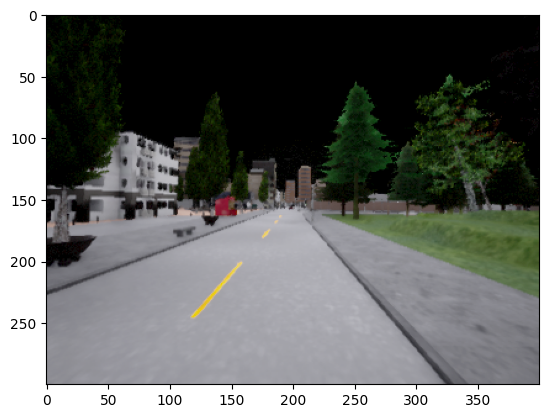

In [5]:
import matplotlib.pyplot as plt
plt.imshow(obs['front_camera'])

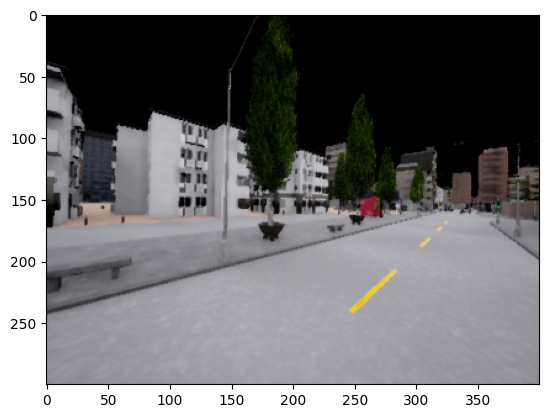

In [6]:
plt.imshow(obs['front_left_camera'])

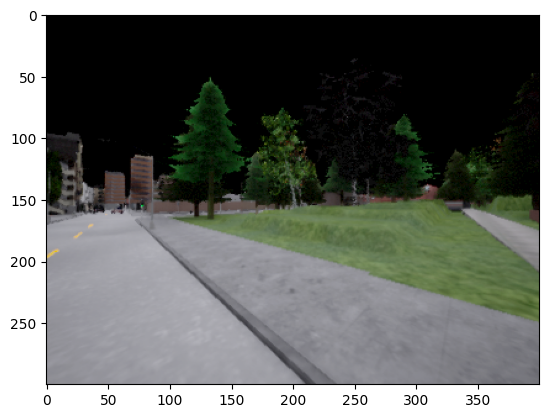

In [7]:
plt.imshow(obs['front_right_camera'])

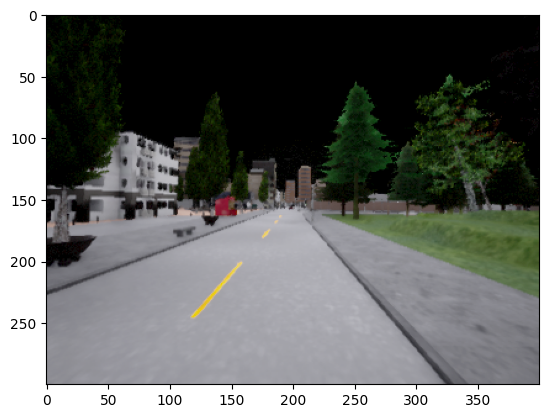

In [8]:
plt.imshow(obs['back_camera'])

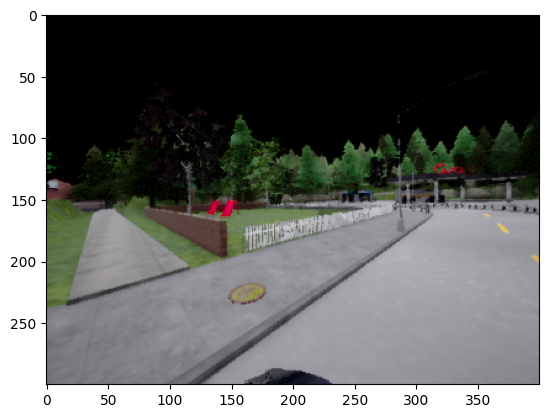

In [9]:
plt.imshow(obs['back_left_camera'])

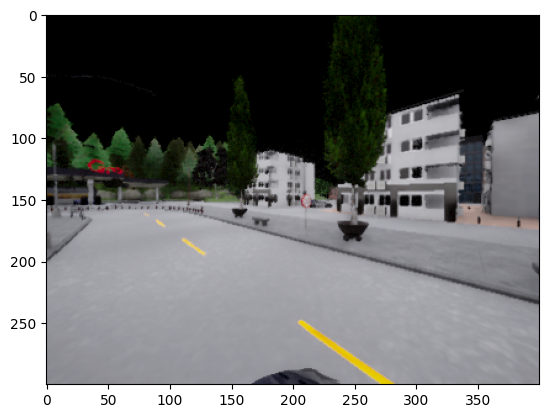

In [10]:
plt.imshow(obs['back_right_camera'])